In [2]:
from __future__ import annotations
from typing import Tuple, List, Dict, KeysView, Iterable
from random import uniform
from gurobipy import Model, tupledict, GurobiError, GRB

In [3]:
Vertex = int
Arc = Tuple[Vertex, Vertex]
Tour = List[Vertex]

class TSPIntance:
    n: int
    x: List[float]
    y: List[float]
    cost: Dict[Arc, float]

    def __init__(self, x: List[float], y: List[float]):
        assert len(x) == len(y), "X and Y coordinate lists must have the same length"

        self.n = len(x)
        self.x = x
        self.y = y
        self.cost = {
            (i, j): ((self.x[i] - self.x[j])**2 + (self.y[i] - self.y[j])**2)**0.5 # we do this because we want to calculate the oklidean distance
            for i in self.vertices()
            for j in self.vertices()
            if i != j
        }

    def vertices(self) -> Iterable[Vertex]:
        return range(self.n)
    
    def arcs(self) -> KeysView:
        return self.cost.keys()

    # we have to include this other method: to get a random instance with n objects
    @staticmethod
    def random(n: int) -> TSPIntance:
        x = [uniform(0, 10) for _ in range(n)] # so I get random numbers from 0 to 10, repeat this n times
        y = [uniform(0, 10) for _ in range(n)]
        return TSPIntance(x=x, y=y)

In [4]:
class TSPSolution:
    tour: Tour # a tour is a list of vertices (see above)
    cost: float

    def __init__(self, tour: Tour, **kwargs): 
        assert 'cost' in kwargs or 'instance' in kwargs, \
            "You must pass the tour cost or a TSP instance to compute it"

        if 'cost' in kwargs:
            self.cost = kwargs.get('cost')
        elif 'instance' in kwargs:
            tsp = kwargs.get('instance')
            self.cost = sum(
                tsp.cost[i, j]
                for i in tour[:-1]
                for j in tour[1:]
            )

        self.tour = tour

    def __str__(self) -> str:
        return "[" + ', '.join(map(str, self.tour)) + f"] - Cost: {self.cost:.2f}"

In [5]:
class BranchAndCutIntegerSolver:
    tsp: TSPIntance
    m: Model
    x: tupledict

    def __init__(self, tsp: TSPIntance):
        self.tsp = tsp
        self.m = Model()
        self.x = self.m.addVars(self.tsp.arcs(), obj=self.tsp.cost, vtype=GRB.BINARY, name='x')
        self.__build_model()

    def __build_model(self) -> None:
        self.m.addConstrs(self.x.sum(i, '*') == 1 for i in self.tsp.vertices()) # here we have Xij -- this is the shortcut '*' meaning to some over something else,, any j that is not i
        self.m.addConstrs(self.x.sum('*', i) == 1 for i in self.tsp.vertices()) # here this is Xji

    def solve(self) -> TSPSolution:
        self.m.setParam(GRB.Param.LazyConstraints, 1) # this is telling python we're trying to use Lazy Constraints
        self.m.optimize(lambda _, where: self.__separate(where=where)) # we are using lamda function, the underscore means it ignores the first parameter and only uses "where", the 'where' means that we are solving a specific thing right now, like for example if where = 2 this means it is currently solving a simplex, if where = 4 it means MIPSOL, found a new integer solution
                                                                       # here the where is for checking whether we found an integeer solution
        if self.m.Status != GRB.OPTIMAL:
            raise RuntimeError("Could not solve TSP model to optimality")
        
        return TSPSolution(tour=self.__tour_starting_at(0), cost=self.m.ObjVal) # ObjVal is the objective value
                                                                                # the final tour, is the tour starting at 0
    
    # FIND SUBTOURS:
    def __separate(self, where: int) -> None: # the procedure that takes an integer solution, creating subtours in this integer solution
        if where != GRB.Callback.MIPSOL: # if we are not in a correct moment, that means that we just found a new integer solution
            return
        
        # if we do find an integer solution:
        remaining = set(self.tsp.vertices()) # the vertices we have not consdiered in the subtour, at some point this set will be empty when we have detected all the subtours, but at the beginning all the vertices are in there 

        # as long as there are still vertices in the remaining set:
        while len(remaining) > 0:
            # Get the first vertex of the set
            start = remaining.pop() # thisbtakes out just a random item from the set
            # start = next(iter(remaining)) # this would do the same
            subtour = self.__tour_starting_at(start)

            if len(subtour) == self.tsp.n: # check if the length of the subtour is the same as the complete tour
                # Feasible tour visiting all vertices
                return
            
            self.__add_sec_for(subtour)

            remaining -= set(subtour) # remove all the vertices from the set that are in the subset
                                    # a = {1, 2, 3 , 4 , 5, 6}
                                    # b = {4, 5}
                                    # a - b = {1, 2, 3, 6}

    def __tour_starting_at(self, i: Vertex) -> Tour:
        tour = [i]
        current = self.__next_vertex(i=i)

        while current != i:
            tour.append(current)
            current = self.__next_vertex(current)

        return tour

    def __next_vertex(self, i: Vertex) -> Vertex:
        for j in self.tsp.vertices():
            if j == i:
                continue

            try:
                # When in a callback

                # we check for all other vetecis that are not i, let's call them j, if they have Xij = 1 , if so then this j is the next vertex and so on
                x = self.m.cbGetSolution(self.x[i,j]) # what vertex are we currently using
            
            except GurobiError: # Gurobi raises an exception if the optimization is over and I am trying to use this function, this is what we use for our own advantage
                # When optimisation is over
                x = self.x[i,j].X # then we use this one (if there is this exception, meaning we are at the last)

            if x > 0.5: # because we don't have exact 0s and 1s sometimes
                return j
            
        raise RuntimeError(f"Vertex {i} has no successor!") # this should never happen
    
    # the constraint for a given subtour:
    def __add_sec_for(self, subtour: Tour) -> None:
        print("Adding a SEC for subtour [" + ', '.join(map(str, subtour)) + "]")
        self.m.cbLazy( # cb stands for callback -> i is in subtour and j is not in subtour
            sum(
                self.x[i, j]
                for i, j in self.tsp.arcs()
                if i in subtour and j not in subtour
            ) >= 1
        )

In [74]:
tsp = TSPIntance.random(n=20)
solver = BranchAndCutIntegerSolver(tsp=tsp)
solution = solver.solve()

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.5.0 23F79)



CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 40 rows, 380 columns and 760 nonzeros
Model fingerprint: 0x481aeea8
Variable types: 0 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Adding a SEC for subtour [0, 1, 9, 2, 3, 7]
Adding a SEC for subtour [4, 17, 11, 8, 5, 10, 14]
Adding a SEC for subtour [6, 18, 16, 15]
Adding a SEC for subtour [12, 13, 19]
Presolve time: 0.01s
Presolved: 40 rows, 380 columns, 760 nonzeros
Variable types: 0 continuous, 380 integer (380 binary)
Adding a SEC for subtour [0, 10]
Adding a SEC for subtour [1, 6, 2]
Adding a SEC for subtour [3, 15]
Adding a SEC for subtour [4, 16]
Adding a SEC for subtour [5, 11, 7]
Adding a SEC for subtour [8, 13]
Adding a SEC for subtour [9, 18]
Adding a SEC for subtour [12, 17]
Adding a SEC for subtour [14, 1

In [7]:
print(solution)

[0, 13, 18, 15, 12, 11, 1, 5, 3, 7, 16, 8, 9, 14, 2, 10, 19, 17, 6, 4] - Cost: 38.67


In [8]:
from itertools import combinations
import time

def tsp_dp(tsp: TSPIntance) -> float:
    """
    Solves the TSP using dynamic programming for the given TSP instance.
    
    Parameters:
    tsp (TSPIntance): An instance of the TSP problem with `n` vertices and `cost` dictionary for arc distances.
    
    Returns:
    float: Minimum tour cost to visit all nodes starting and ending at the depot (node 0).
    """
    n = tsp.n
    cost = tsp.cost  # Arc cost dictionary
    
    # Memoization dictionary to store subproblem solutions
    memo = {}
    
    def dp(subset, last):
        """
        Recursive DP function to calculate minimum path cost to `last` in `subset`.
        
        Parameters:
        subset: A frozenset representing a subset of visited vertices.
        last: The last vertex visited in this subset.
        
        Returns:
        float: Minimum cost to complete the path.
        """
        if (subset, last) in memo:
            return memo[(subset, last)]
        
        # Base case: if only one vertex in subset, return cost from depot (0) to last vertex
        if len(subset) == 1:
            return cost[(0, last)]
        
        # Recursive case: calculate minimum cost by visiting each possible previous vertex
        subset_without_last = subset - {last}
        result = min(dp(subset_without_last, k) + cost[(k, last)] for k in subset_without_last)
        
        # Store result in memoization dictionary
        memo[(subset, last)] = result
        return result

    # Calculate minimum tour cost starting and ending at the depot (vertex 0)
    full_set = frozenset(range(1, n))  # All nodes except the depot
    min_tour_cost = min(dp(full_set, last) + cost[(last, 0)] for last in full_set)
    
    return min_tour_cost


In [9]:
# Generate a random TSP instance with n vertices
tsp_instance = TSPIntance.random(n=20)  # Adjust 'n' so it does this from 1 to 20 and we save the times and then we plot the graph 

# Solve using Branch and Cut
solver = BranchAndCutIntegerSolver(tsp=tsp_instance)
start_time_bc = time.time()
solution_bc = solver.solve()
end_time_bc = time.time()

# Solve using Dynamic Programming
start_time_dp = time.time()
dp_tour_cost = tsp_dp(tsp_instance)
end_time_dp = time.time()

# Display results
print("Branch and Cut Solution:", solution_bc)
print(f"Branch and Cut Tour Cost: {solution_bc.cost:.2f}")
print(f"Branch and Cut Execution Time: {end_time_bc - start_time_bc:.4f} seconds\n")

print(f"Dynamic Programming Tour Cost: {dp_tour_cost:.2f}")
print(f"Dynamic Programming Execution Time: {end_time_dp - start_time_dp:.4f} seconds\n")

# Check if both solutions match
if abs(solution_bc.cost - dp_tour_cost) < 1e-6:
    print("Both methods found the same optimal tour cost.")
else:
    print("The methods found different tour costs, indicating a possible discrepancy.")

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 40 rows, 380 columns and 760 nonzeros
Model fingerprint: 0xe5d8dcbb
Variable types: 0 continuous, 380 integer (380 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Adding a SEC for subtour [0, 1, 9, 2, 3, 7]
Adding a SEC for subtour [4, 17, 11, 8, 5, 10, 14]
Adding a SEC for subtour [6, 18, 16, 15]
Adding a SEC for subtour [12, 13, 19]
Presolve time: 0.00s
Presolved: 40 rows, 380 columns, 760 nonzeros
Variable types: 0 continuous, 380 integer (380 binary)
Adding a SEC for subtour [0, 12]
Adding a SEC for subtour [1, 13]
Adding a SEC for subtour [2, 5]
Adding a SEC for subtour [3, 4]
Adding a SEC for subtour [6, 9]
Adding a SEC f

Here we're doing the plot, to see the relationship:

Solving for n = 10...
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 90 columns and 180 nonzeros
Model fingerprint: 0x56551e87
Variable types: 0 continuous, 90 integer (90 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 58.4978861
Presolve time: 0.00s
Presolved: 20 rows, 90 columns, 180 nonzeros
Variable types: 0 continuous, 90 integer (90 binary)

Root relaxation: objective 2.279882e+01, 15 iterations, 0.00 seconds (0.00 work units)
Adding a SEC for subtour [0, 6, 7]
Adding a SEC for subtour [1, 2, 9]
Adding a SEC for subtour [3, 8]
Adding a SEC for subtour [4, 5]

    Nodes    |    Current Node    |     Objective Bounds      | 

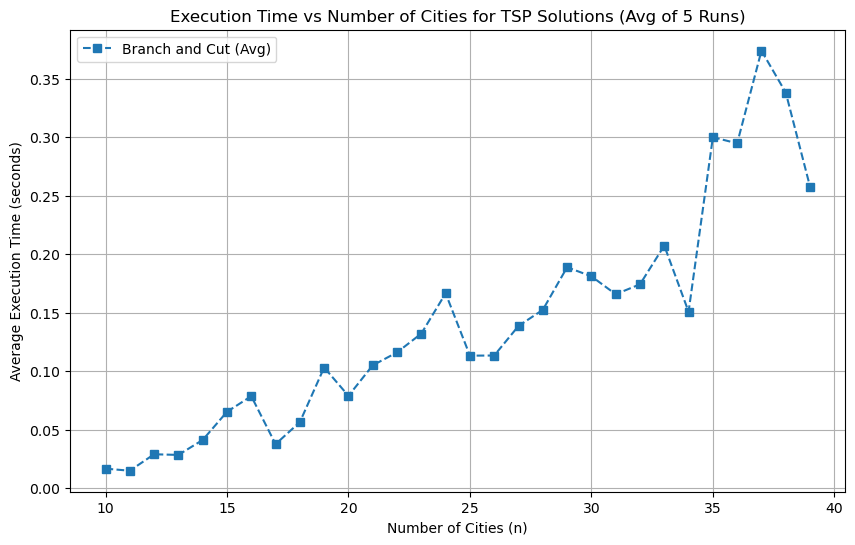

In [115]:
import matplotlib.pyplot as plt
import time
import numpy as np
from random import uniform

# Number of repetitions for each n
repeats = 5

# Initialize data storage
n_values = range(10, 40)  # Number of cities from 2 to 15
bc_times = []  # Store average execution times for Branch and Cut
dp_times = []  # Store average execution times for Dynamic Programming

# Loop through each value of n
for n in n_values:
    print(f"Solving for n = {n}...")

    # Measure execution times over multiple runs
    bc_time_samples = []
    dp_time_samples = []

    for _ in range(repeats):
        # Generate a completely new random TSP instance for this run
        tsp_instance = TSPIntance.random(n=n)

        # Branch and Cut
        solver = BranchAndCutIntegerSolver(tsp=tsp_instance)
        start_time_bc = time.time()
        try:
            solver.solve()
        except RuntimeError:
            print("Branch and Cut failed to solve.")
            bc_time_samples.append(np.nan)  # Mark as NaN if it fails
            continue
        end_time_bc = time.time()
        bc_time_samples.append(end_time_bc - start_time_bc)

    

    # Compute averages (or use median if you prefer more robustness)
    bc_times.append(np.nanmean(bc_time_samples))  # Use nanmean to ignore failures
  

# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(n_values, bc_times, label="Branch and Cut (Avg)", marker='s', linestyle='--')
plt.xlabel("Number of Cities (n)")
plt.ylabel("Average Execution Time (seconds)")
plt.title(f"Execution Time vs Number of Cities for TSP Solutions (Avg of {repeats} Runs)")
plt.legend()
plt.grid()
plt.show()